# Sauim bicolor Vocalization Classifier and Analysis

This notebook demonstrates how to use the Perch bird vocalization classifier model from TensorFlow Hub to extract embeddings from audio files of Sauim bicolor primate and perform analysis on the extracted embeddings, such as hierarchical clustering.

The notebook covers the following steps:

1.  **Setup**: Installing necessary libraries and loading the Perch model.
2.  **Data Loading**: Downloading example audio files and a CSV file containing labels.
3.  **Feature Extraction**: Defining and using a function to extract embeddings and spectrograms from audio segments.
4.  **Spectrogram Visualization**: Plotting spectrograms to visualize the audio data.
5.  **Clustering Analysis**: Performing hierarchical clustering on the extracted embeddings and visualizing the results as a dendrogram.

In [1]:
%pip install tensorflow_hub -q

In [2]:
import csv
import librosa
import gdown
import zipfile
import shutil
import os
import soundfile as sf
from scipy import signal
from scipy.io import wavfile
from tqdm.notebook import trange, tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()

# Load Perch model.
model = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8')

In [3]:
# Remove the directory and all its contents
if os.path.exists('embedding_vectors'):
    shutil.rmtree('embedding_vectors')
    print("Folder 'embedding_vectors' removed.")

if os.path.exists('Parque do Mindú'):
    shutil.rmtree('Parque do Mindú')
    print("Folder 'Parque do Mindú' removed.")

if os.path.exists('MinduPark_38'):
    shutil.rmtree('MinduPark_38')
    print("Folder 'MinduPark_38' removed.")

Automatically download the necessary files

In [4]:
!wget https://github.com/juancolonna/Sauim/raw/main/records/records.csv -O records.csv
!wget https://github.com/juancolonna/Sauim/raw/main/records/Sauim.wav -O Sauim.wav
!wget https://github.com/juancolonna/Sauim/raw/main/records/Anurans.wav -O Anurans.wav
!wget https://github.com/juancolonna/Sauim/raw/main/records/Anthrophony.wav -O Anthrophony.wav
!wget https://github.com/juancolonna/Sauim/raw/main/records/Background.wav -O Background.wav
!wget https://github.com/juancolonna/Sauim/raw/main/records/Birds.wav -O Birds.wav
!wget https://github.com/juancolonna/Sauim/raw/main/records/Geophony.wav -O Geophony.wav
!wget https://github.com/juancolonna/Sauim/raw/main/records/Mindu_Saguinus%20bicolor_02.02.19-000.wav -O Mindu_Saguinus_bicolor_02.02.19-000.wav
# !wget https://github.com/juancolonna/Sauim/raw/main/records/Mindu_Saguinus_bicolor_02.02.19-000_bandpass_filtered.wav -O Mindu_Saguinus_bicolor_02.02.19-000_bandpass_filtered.wav

!wget https://github.com/juancolonna/Sauim/raw/main/records/Parque_do_Mindú.zip -O Parque_do_Mindú.zip
!unzip -q Parque_do_Mindú.zip

!wget https://github.com/juancolonna/Sauim/raw/main/records/Parque_do_Mindu_38.zip -O Parque_do_Mindu_38.zip
!unzip -q Parque_do_Mindu_38.zip -d Parque_do_Mindu_38

--2025-08-27 04:56:46--  https://github.com/juancolonna/Sauim/raw/main/records/records.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/juancolonna/Sauim/main/records/records.csv [following]
--2025-08-27 04:56:46--  https://raw.githubusercontent.com/juancolonna/Sauim/main/records/records.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4060 (4.0K) [text/plain]
Saving to: ‘records.csv’

records.csv         100%[===================>]   3.96K  --.-KB/s    in 0s      

2025-08-27 04:56:47 (44.4 MB/s) - ‘records.csv’ saved [4060/4060]

--2025-08-27 04:56:47--  https://github.com/juancolonna

In [5]:
def extract_embeddings(file: str, wlen: int, hop_len: int, bandpass_filter: bool):
    """
    Extracts embedding vectors and spectrograms from an audio file.

    Args:
        file (str): Path to the audio file.
        wlen (int): Window length in samples.
        hop_len (int): Hop length in samples.

    Returns:
        tuple: (list of embedding vectors, list of spectrogram arrays)

    Example:
        >>> sr = 32000  # Sampling rate in Hz
        >>> window_len = int(5 * sr)  # 5-second window
        >>> emb, specs = extract_embeddings('Sauim.wav', wlen=window_len, hop_len=window_len)
        >>> np.save('sauim_embedding_vectors.npy', emb)
        >>> np.save('sauim_spectrograms.npy', specs)
    """

    y, sr = librosa.load(file, sr=32000)  # Load audio
    y = y / np.max(np.abs(y)) # Normalize amplitude

    if bandpass_filter:
        # 2) Design a high-pass Butterworth (4th order). Nyquist = fs/2, SciPy handles normalization with fs=
        sos = signal.butter(N=4, Wn=[5000.0, 10000.0], btype="bandpass", fs=sr, output="sos")
        # 3) Zero-phase filtering (filtfilt) along the time axis (axis=0 for (samples, channels))
        y = signal.sosfiltfilt(sos, y.astype(np.float32), axis=0)
        wavfile.write(file[:-4]+'_filtered.wav', sr, y.astype(np.float32))

    embedding_vectors = []
    spectrograms = []

    for time in tqdm(range(0, len(y), hop_len)):
        if time + wlen < len(y):
            segment = y[time:time+wlen]
            model_outputs = model.infer_tf(segment[np.newaxis, :])
            embedding_vectors.append(model_outputs['embedding'].numpy()[0])
            spectrograms.append(model_outputs['frontend'][0].T.numpy())

    return embedding_vectors, spectrograms

def plot_spectrogram(species: str, spectrograms):
    """
    Plots a Mel spectrogram in dB scale for a given species.

    Args:
        species (str): Species name.
        spectrograms (ndarray): Spectrogram array.
        sr (int): Sampling rate in Hz.

    Example:
        >>> sr = 32000
        >>> window_len = int(5 * sr)
        >>> emb, specs = extract_embeddings('Sauim.wav', wlen=window_len, hop_len=window_len)
        >>> # Plot the first extracted spectrogram
        >>> plot_spectrogram("Saguinus bicolor", specs[0], sr)
    """
    S_dB = librosa.power_to_db(spectrograms, ref=np.max) # Convert to decibels

    plt.figure(figsize=(10, 3))
    librosa.display.specshow(S_dB, sr=32000, x_axis='time', y_axis='mel',
                            hop_length=256+64, # Provide hop_length for correct time axis
                            cmap='viridis') # Ensure origin is lower for standard freq plot

    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of a 5-second segment of {species}')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency (Hz)') # Librosa will automatically format this as Mel-Hz

    plt.tight_layout()
    plt.show()

Extract embeddings and spectrograms for a 'Sauim.wav' audio file and save them as NumPy arrays.

In [6]:
os.makedirs("embedding_vectors", exist_ok=True)  # cria se não existir

sr = 32000 # Sampling rate (Hz)
window_len = int(5*sr) # 5-second window length in samples

In [7]:
# Extract embeddings and spectrograms for each 5-second segment
sauim_vectors, sauim_spectrograms = extract_embeddings('Sauim.wav',
                                                     wlen=window_len,
                                                     hop_len=window_len,
                                                     bandpass_filter=False)

# Save outputs to .npy files
np.save('embedding_vectors/sauim_vectors.npy', sauim_vectors)

# Extract embeddings and spectrograms for each 5-second segment
sauim_vectors_filtered, _ = extract_embeddings('Sauim.wav',
                                                     wlen=window_len,
                                                     hop_len=window_len,
                                                     bandpass_filter=True)

# Save outputs to .npy files
np.save('embedding_vectors/sauim_vectors_filtered.npy', sauim_vectors_filtered)

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

Background noise segments for anomaly data

In [8]:
background_vectors, background_spectrograms = extract_embeddings('Background.wav',
                                                     wlen=window_len,
                                                     hop_len=window_len,
                                                           bandpass_filter=False)

np.save('embedding_vectors/background_vectors.npy', background_vectors)

# Extract embeddings and spectrograms for each 5-second segment
background_vectors_filtered, _ = extract_embeddings('Background.wav',
                                                     wlen=window_len,
                                                     hop_len=window_len,
                                                     bandpass_filter=True)

# Save outputs to .npy files
np.save('embedding_vectors/background_vectors_filtered.npy', background_vectors_filtered)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Anuran calls used as negative class

In [9]:
anurans_vectors, anurans_spectrograms = extract_embeddings('Anurans.wav',
                                                     wlen=window_len,
                                                     hop_len=int(window_len/2),
                                                     bandpass_filter=False)

np.save('embedding_vectors/anurans_vectors.npy', anurans_vectors)

# Extract embeddings and spectrograms for each 5-second segment
anurans_vectors_filtered, _ = extract_embeddings('Anurans.wav',
                                                     wlen=window_len,
                                                     hop_len=int(window_len/2),
                                                     bandpass_filter=True)

# Save outputs to .npy files
np.save('embedding_vectors/anurans_vectors_filtered.npy', anurans_vectors_filtered)

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Bird calls used as negative class

In [10]:
birds_vectors, birds_spectrograms = extract_embeddings('Birds.wav',
                                                     wlen=window_len,
                                                     hop_len=window_len,
                                                     bandpass_filter=False)

np.save('embedding_vectors/birds_vectors.npy', birds_vectors)

# Extract embeddings and spectrograms for each 5-second segment
birds_vectors_filtered, _ = extract_embeddings('Birds.wav',
                                                     wlen=window_len,
                                                     hop_len=window_len,
                                                     bandpass_filter=True)

# Save outputs to .npy files
np.save('embedding_vectors/birds_vectors_filtered.npy', birds_vectors_filtered)

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

A soundscape record used for new sauim detections

In [11]:
step = 1
hop_len = int(step*sr) # emulates an sliding window of 5 sec length and 1 sec step

soundscape_vectors, soundscape_spectrograms = extract_embeddings('Mindu_Saguinus_bicolor_02.02.19-000.wav',
                                                     wlen=window_len,
                                                     hop_len=hop_len,
                                                     bandpass_filter=False)

np.save('embedding_vectors/soundscape_vectors.npy', soundscape_vectors)

soundscape_vectors_filtered, soundscape_spectrograms_filtered = extract_embeddings('Mindu_Saguinus_bicolor_02.02.19-000.wav',
                                                     wlen=window_len,
                                                     hop_len=hop_len,
                                                     bandpass_filter=True)

np.save('embedding_vectors/soundscape_vectors_filtered.npy', soundscape_vectors_filtered)

  0%|          | 0/564 [00:00<?, ?it/s]

  0%|          | 0/564 [00:00<?, ?it/s]

In [12]:
step = 2
hop_len = int(step*sr) # emulates an sliding window of 5 sec length and 1 sec step

anthrophony_vectors, anthrophony_spectrograms = extract_embeddings('Anthrophony.wav',
                                                     wlen=window_len,
                                                     hop_len=hop_len,
                                                     bandpass_filter=False)

np.save('embedding_vectors/anthrophony_vectors.npy', anthrophony_vectors)

# Extract embeddings and spectrograms for each 5-second segment
anthrophony_vectors_filtered, _ = extract_embeddings('Anthrophony.wav',
                                                     wlen=window_len,
                                                     hop_len=hop_len,
                                                     bandpass_filter=True)

# Save outputs to .npy files
np.save('embedding_vectors/anthrophony_vectors_filtered.npy', anthrophony_vectors_filtered)

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

In [13]:
step = 2
hop_len = int(step*sr) # emulates an sliding window of 5 sec length and 1 sec step

geophony_vectors, geophony_spectrograms = extract_embeddings('Geophony.wav',
                                                     wlen=window_len,
                                                     hop_len=hop_len,
                                                     bandpass_filter=False)

np.save('embedding_vectors/geophony_vectors.npy', geophony_vectors)

# Extract embeddings and spectrograms for each 5-second segment
geophony_vectors_filtered, _ = extract_embeddings('Geophony.wav',
                                                     wlen=window_len,
                                                     hop_len=hop_len,
                                                     bandpass_filter=True)

# Save outputs to .npy files
np.save('embedding_vectors/geophony_vectors_filtered.npy', geophony_vectors_filtered)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [18]:
!zip -r embedding_vectors.zip embedding_vectors

  adding: embedding_vectors/ (stored 0%)
  adding: embedding_vectors/soundscape_vectors_filtered.npy (deflated 8%)
  adding: embedding_vectors/sauim_vectors_filtered.npy (deflated 8%)
  adding: embedding_vectors/anurans_vectors.npy (deflated 8%)
  adding: embedding_vectors/birds_vectors_filtered.npy (deflated 8%)
  adding: embedding_vectors/sauim_vectors.npy (deflated 8%)
  adding: embedding_vectors/soundscape_vectors.npy (deflated 8%)
  adding: embedding_vectors/geophony_vectors_filtered.npy (deflated 8%)
  adding: embedding_vectors/birds_vectors.npy (deflated 8%)
  adding: embedding_vectors/anthrophony_vectors.npy (deflated 8%)
  adding: embedding_vectors/background_vectors.npy (deflated 8%)
  adding: embedding_vectors/anthrophony_vectors_filtered.npy (deflated 8%)
  adding: embedding_vectors/anurans_vectors_filtered.npy (deflated 8%)
  adding: embedding_vectors/geophony_vectors.npy (deflated 8%)
  adding: embedding_vectors/background_vectors_filtered.npy (deflated 8%)


## Audio files for the Ocupancy model

In [14]:
os.makedirs("MinduPark", exist_ok=True)  # cria se não existir

step = 2
hop_len = int(step*sr) # emulates an sliding window of 5 sec length and 1 sec step

for i, file in enumerate(os.listdir('Parque do Mindú')):
    MinduPark_vectors, _ = extract_embeddings("Parque do Mindú/"+file,
                                                        wlen=window_len,
                                                        hop_len=hop_len,
                                                        bandpass_filter=False)

    np.save('MinduPark/MinduPark_vectors_'+str(i)+'.npy', MinduPark_vectors)

    MinduPark_vectors_filtered, _ = extract_embeddings("Parque do Mindú/"+file,
                                                        wlen=window_len,
                                                        hop_len=hop_len,
                                                        bandpass_filter=True)

    np.save('MinduPark/MinduPark_vectors_filtered_'+str(i)+'.npy', MinduPark_vectors_filtered)

!zip -r MinduPark.zip MinduPark

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/1039 [00:00<?, ?it/s]

  0%|          | 0/1039 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/421 [00:00<?, ?it/s]

  0%|          | 0/1322 [00:00<?, ?it/s]

  0%|          | 0/1322 [00:00<?, ?it/s]

  adding: MinduPark/ (stored 0%)
  adding: MinduPark/MinduPark_vectors_filtered_7.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_filtered_5.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_filtered_6.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_filtered_0.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_3.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_1.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_0.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_5.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_filtered_3.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_filtered_4.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_7.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_filtered_1.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_2.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_6.npy (deflated 8%)
  adding: MinduPark/MinduPark_vectors_filtered_2.npy (deflated 8%)
  adding: MinduPark/Mindu

In [15]:
os.makedirs("MinduPark_38", exist_ok=True)  # cria se não existir

step = 1
hop_len = int(step*sr) # emulates an sliding window of 5 sec length and 1 sec step

for i, file in enumerate(os.listdir('Parque_do_Mindu_38/Parque do Mindú')):
    MinduPark_vectors, _ = extract_embeddings("Parque_do_Mindu_38/Parque do Mindú/"+file,
                                                        wlen=window_len,
                                                        hop_len=hop_len,
                                                        bandpass_filter=False)

    np.save('MinduPark_38/MinduPark_vectors_'+str(i)+'.npy', MinduPark_vectors)

    MinduPark_vectors_filtered, _ = extract_embeddings("Parque_do_Mindu_38/Parque do Mindú/"+file,
                                                        wlen=window_len,
                                                        hop_len=hop_len,
                                                        bandpass_filter=True)

    np.save('MinduPark_38/MinduPark_vectors_filtered_'+str(i)+'.npy', MinduPark_vectors_filtered)

!zip -r MinduPark_38.zip MinduPark_38

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/1624 [00:00<?, ?it/s]

  0%|          | 0/1624 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/564 [00:00<?, ?it/s]

  0%|          | 0/564 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  adding: MinduPark_38/ (stored 0%)
  adding: MinduPark_38/MinduPark_vectors_filtered_11.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_filtered_15.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_filtered_28.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_18.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_8.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_24.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_filtered_19.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_16.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_14.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_26.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_filtered_7.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_33.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_filtered_5.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_31.npy (deflated 8%)
  adding: MinduPark_38/MinduPark_vectors_filt

Load labels, compute cosine distance matrix from embedding vectors, perform hierarchical clustering, and plot a dendrogram.

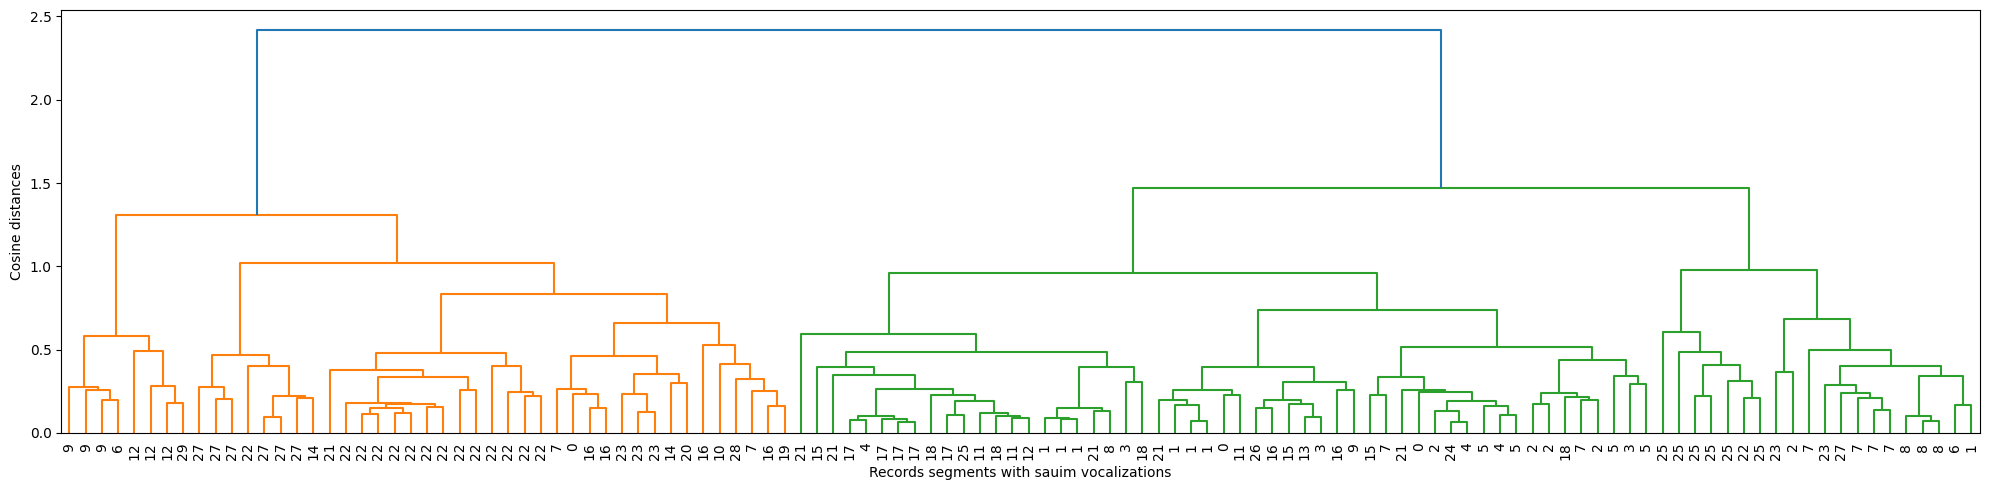

In [16]:
# 1. Load labels from CSV
records = pd.read_csv('records.csv')  # adjust path if needed
labels = records['Bosque_S.bicolor_12.4.19-000'].tolist()

# Encode labels as integers
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# 2. Compute cosine distance matrix (condensed form)
cosine_distances = pdist(sauim_vectors, metric='cosine')

# 3. Perform hierarchical clustering
Z = linkage(cosine_distances, method='ward')  # try 'ward', 'complete', etc.

# 4. Plot dendrogram
plt.figure(figsize=(20, 5))
dendrogram(Z, labels=encoded_labels, leaf_font_size=10)
plt.xlabel("Records segments with sauim vocalizations")
plt.ylabel("Cosine distances")
plt.tight_layout()
plt.savefig("dendongram.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
for i in zip(encoded_labels,labels):
    print(i)

(np.int64(23), 'Bosque_S.bicolor_12.4.19-000')
(np.int64(23), 'Bosque_S.bicolor_12.4.19-000')
(np.int64(23), 'Bosque_S.bicolor_12.4.19-000')
(np.int64(23), 'Bosque_S.bicolor_12.4.19-000')
(np.int64(23), 'Bosque_S.bicolor_12.4.19-000')
(np.int64(0), 'Bosque_S.bicolor +parauacu_11.4.19-009')
(np.int64(0), 'Bosque_S.bicolor +parauacu_11.4.19-009')
(np.int64(0), 'Bosque_S.bicolor +parauacu_11.4.19-009')
(np.int64(24), 'Bosque_S.bicolor_9.4.19-000')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_1

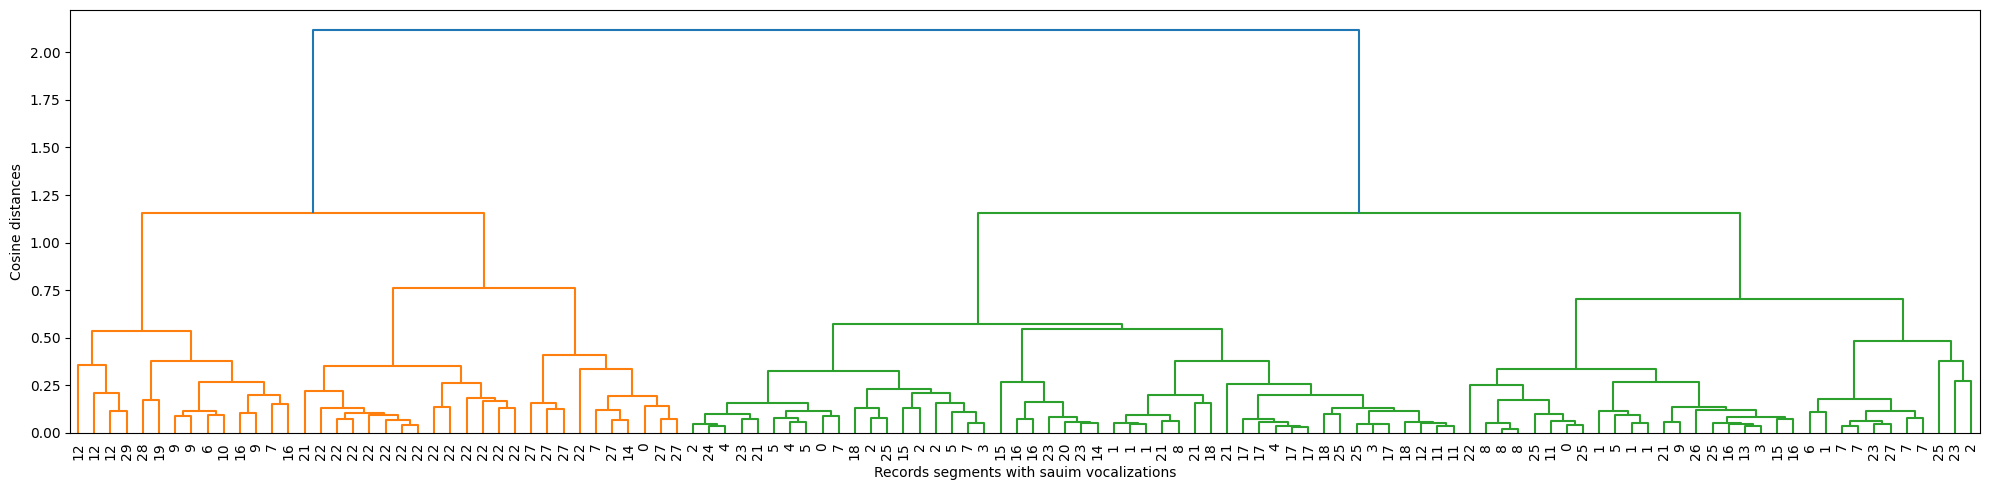

In [19]:
# 1. Load labels from CSV
records = pd.read_csv('records.csv')  # adjust path if needed
labels = records['Bosque_S.bicolor_12.4.19-000'].tolist()

# Encode labels as integers
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# 2. Compute cosine distance matrix (condensed form)
cosine_distances = pdist(sauim_vectors_filtered, metric='cosine')

# 3. Perform hierarchical clustering
Z = linkage(cosine_distances, method='ward')  # try 'ward', 'complete', etc.

# 4. Plot dendrogram
plt.figure(figsize=(20, 5))
dendrogram(Z, labels=encoded_labels, leaf_font_size=10)
plt.xlabel("Records segments with sauim vocalizations")
plt.ylabel("Cosine distances")
plt.tight_layout()
plt.savefig("dendongram_filtered.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()